## Importing GeoAI for Spatial Data preparation

In [1]:
import geoai

## Setting URL for training images, test_images

In [2]:
# Contains a GeoTiff image which not only has an aerial view of buildings but also geospatial data
train_raster_url = (
    "https://huggingface.co/datasets/giswqs/geospatial/resolve/main/naip_rgb_train.tif"
)
# Contains a list of polygons that highlight buildings
train_vector_url = "https://huggingface.co/datasets/giswqs/geospatial/resolve/main/naip_train_buildings.geojson"
# Test image
test_raster_url = (
    "https://huggingface.co/datasets/giswqs/geospatial/resolve/main/naip_test.tif"
)

## Downloading Data

In [3]:
train_raster_path = geoai.download_file(train_raster_url)
train_vector_path = geoai.download_file(train_vector_url)
test_raster_path = geoai.download_file(test_raster_url)

File already exists: naip_rgb_train.tif
File already exists: naip_train_buildings.geojson
File already exists: naip_test.tif


## Checking GeoTiff Data

In [4]:
geoai.get_raster_info(train_raster_path)

{'driver': 'GTiff',
 'width': 2503,
 'height': 1126,
 'count': 3,
 'dtype': 'uint8',
 'crs': 'EPSG:26911',
 'transform': Affine(0.6000000000000046, 0.0, 454780.8,
        0.0, -0.6, 5278242.6),
 'bounds': BoundingBox(left=454780.8, bottom=5277567.0, right=456282.6, top=5278242.6),
 'resolution': (0.6000000000000046, 0.6),
 'nodata': None,
 'band_stats': [{'band': 1,
   'min': 12.0,
   'max': 251.0,
   'mean': 150.6730747259594,
   'std': 48.01908734374099},
  {'band': 2,
   'min': 49.0,
   'max': 251.0,
   'mean': 141.92468895229808,
   'std': 43.46595463573498},
  {'band': 3,
   'min': 53.0,
   'max': 251.0,
   'mean': 120.89909373405554,
   'std': 41.78086244480776}]}

## Viewing Geotiff Data

In [5]:
geoai.view_raster(train_raster_path)

## Overlaying Geojson data with GeoTiff

In [6]:
geoai.view_vector_interactive(train_vector_path, tiles=train_raster_path)

## Generating tiles to make it easier to learn segmentation for buildings

In [7]:
out_folder = "buildings"
tiles = geoai.export_geotiff_tiles(
    in_raster=train_raster_path,
    out_folder=out_folder,
    in_class_data=train_vector_path,
    tile_size=64,
    stride=32,
    buffer_radius=0,
)


Raster info for naip_rgb_train.tif:
  CRS: EPSG:26911
  Dimensions: 2503 x 1126
  Resolution: (0.6000000000000046, 0.6)
  Bands: 3
  Bounds: BoundingBox(left=454780.8, bottom=5277567.0, right=456282.6, top=5278242.6)
Loaded 735 features from naip_train_buildings.geojson
Vector CRS: EPSG:4326
Reprojecting features from EPSG:4326 to EPSG:26911
Found 1 unique classes: ['building']


Generated: 2730, With features: 2172: 100%|██████████| 2730/2730 [02:23<00:00, 19.00it/s]


------- Export Summary -------
Total tiles exported: 2730
Tiles with features: 2172 (79.6%)
Average feature pixels per tile: 885.0
Output saved to: buildings

------- Georeference Verification -------


## Training

In [8]:
geoai.train_segmentation_model(
    images_dir=f"{out_folder}/images",
    labels_dir=f"{out_folder}/labels",
    output_dir=f"{out_folder}/unet_models",
    architecture="unet",
    encoder_name="resnet34",
    encoder_weights="imagenet",
    num_channels=3,
    num_classes=2,  # background and building
    batch_size=8,
    num_epochs=5,
    learning_rate=0.001,
    val_split=0.2,
    verbose=True,
    save_best_only=True,
)

Using device: cpu
Found 2730 image files and 2730 label files
Training on 2184 images, validating on 546 images
Checking image sizes for compatibility...
All sampled images have the same size: (64, 64)
No resizing needed.
Testing data loader...
Data loader test passed.
Starting training with unet + resnet34
Model parameters: 24,436,514
Epoch: 1, Batch: 1/273, Loss: 0.5649, Time: 0.86s
Epoch: 1, Batch: 11/273, Loss: 0.3862, Time: 5.35s
Epoch: 1, Batch: 21/273, Loss: 0.4624, Time: 5.30s
Epoch: 1, Batch: 31/273, Loss: 0.2321, Time: 5.23s
Epoch: 1, Batch: 41/273, Loss: 0.4427, Time: 5.32s
Epoch: 1, Batch: 51/273, Loss: 0.3547, Time: 5.27s
Epoch: 1, Batch: 61/273, Loss: 0.2400, Time: 5.35s
Epoch: 1, Batch: 71/273, Loss: 0.1826, Time: 5.32s
Epoch: 1, Batch: 81/273, Loss: 0.2950, Time: 5.28s
Epoch: 1, Batch: 91/273, Loss: 0.2620, Time: 5.35s
Epoch: 1, Batch: 101/273, Loss: 0.2030, Time: 5.34s
Epoch: 1, Batch: 111/273, Loss: 0.3125, Time: 5.40s
Epoch: 1, Batch: 121/273, Loss: 0.2492, Time: 5.3

In [9]:
masks_path = "naip_test_semantic_prediction.tif"
model_path = f"{out_folder}/unet_models/best_model.pth"

## Inference

In [10]:
# Run semantic segmentation inference
geoai.semantic_segmentation(
    input_path=test_raster_path,
    output_path=masks_path,
    model_path=model_path,
    architecture="unet",
    encoder_name="resnet34",
    num_channels=3,
    num_classes=2,
    window_size=64,
    overlap=32,
    batch_size=4,
)

Input file format: GeoTIFF (.tif)
Processing 4410 windows...


4558it [00:46, 98.41it/s]                           


Predicted classes: 2 classes, Background: 90.1%
Inference completed in 46.89 seconds
Saved prediction to naip_test_semantic_prediction.tif


In [11]:
# Run inference with probability output
probability_path = "naip_test_probability_map.tif"

geoai.semantic_segmentation(
    input_path=test_raster_path,
    output_path=masks_path,
    model_path=model_path,
    architecture="unet",
    encoder_name="resnet34",
    num_channels=3,
    num_classes=2,
    window_size=64,
    overlap=32,
    batch_size=4,
    probability_path=probability_path,  # Output probability map
)

Input file format: GeoTIFF (.tif)
Processing 4410 windows...


4558it [00:46, 97.33it/s]                           


Predicted classes: 2 classes, Background: 90.1%
Inference completed in 47.40 seconds
Saved prediction to naip_test_semantic_prediction.tif
Saved probability map to naip_test_probability_map.tif


## Visualization

In [12]:
geoai.view_raster(
    probability_path, indexes=[2], basemap=test_raster_path, backend="ipyleaflet"
)

Map(center=[47.6464835, -117.59043650000001], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom…

In [13]:
masks_path_threshold = "naip_test_semantic_prediction_threshold2.tif"

geoai.semantic_segmentation(
    input_path=test_raster_path,
    output_path=masks_path_threshold,
    model_path=model_path,
    architecture="unet",
    encoder_name="resnet34",
    num_channels=3,
    num_classes=2,
    window_size=512,
    overlap=256,
    batch_size=4,
    probability_threshold=0.3,  # Only classify as building if probability >= 0.7
)

Input file format: GeoTIFF (.tif)
Processing 65 windows...


84it [00:28,  2.98it/s]                        


Using probability threshold: 0.3
Predicted classes: 2 classes, Background: 89.0%
Inference completed in 28.64 seconds
Saved prediction to naip_test_semantic_prediction_threshold2.tif


In [14]:
output_vector_path = "naip_test_semantic_prediction.geojson"
gdf = geoai.orthogonalize(masks_path, output_vector_path, epsilon=2)

Processing 1150 features...


Converting features: 100%|██████████| 1150/1150 [00:08<00:00, 138.26shape/s]


Saving to naip_test_semantic_prediction.geojson...
Done!


In [15]:
gdf_props = geoai.add_geometric_properties(gdf, area_unit="m2", length_unit="m")

In [16]:
geoai.view_raster(masks_path, nodata=0, basemap=test_raster_path, backend="ipyleaflet")

Map(center=[47.6464835, -117.59043650000001], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom…

In [17]:
geoai.view_vector_interactive(gdf_props, column="area_m2", tiles=test_raster_path)

In [18]:
geoai.create_split_map(
    left_layer=gdf,
    right_layer=test_raster_path,
    left_args={"style": {"color": "red", "fillOpacity": 0.2}},
    basemap=test_raster_path,
)

Map(center=[47.6464835, -117.59043650000001], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom…

## Performance Analysis

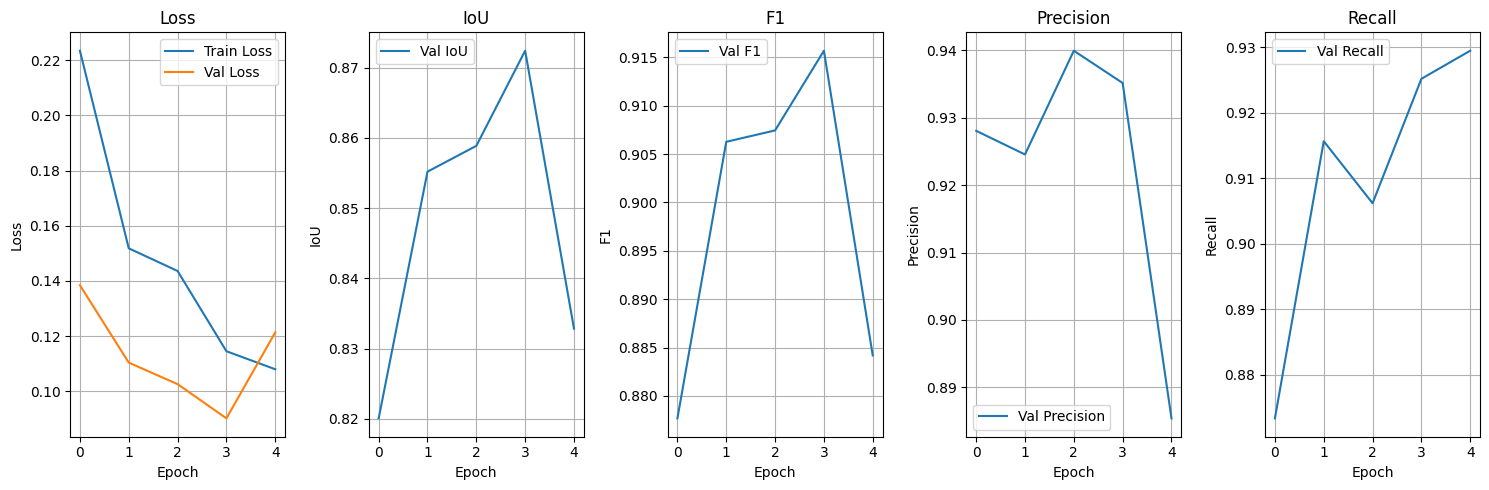


=== Performance Metrics Summary ===
IoU     - Best: 0.8724 | Final: 0.8329
F1      - Best: 0.9157 | Final: 0.8842
Precision - Best: 0.9399 | Final: 0.8854
Recall  - Best: 0.9294 | Final: 0.9294
Val Loss - Best: 0.0902 | Final: 0.1213



,epoch,train_loss,val_loss,val_iou,val_f1,val_precision,val_recall
0,1,0.223426,0.138459,0.820086,0.877687,0.928040,0.873375
1,2,0.151817,0.110397,0.855196,0.906269,0.924533,0.915641
2,3,0.143602,0.102594,0.858869,0.907446,0.939914,0.906179
3,4,0.114521,0.090199,0.872410,0.915685,0.935126,0.925158
4,5,0.107989,0.121338,0.832855,0.884191,0.885419,0.929440


In [19]:
geoai.plot_performance_metrics(
    history_path=f"{out_folder}/unet_models/training_history.pth",
    figsize=(15, 5),
    verbose=True,
)